<a href="https://www.kaggle.com/code/daiqing2009/ocr-performance-analysis-on-license-plates?scriptVersionId=172543186" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# OCR Performance Analysis on LICENSE PLATES
This notebook get hint of https://www.kaggle.com/code/aslanahmedov/automatic-number-plate-recognition, which utilized almost all the datasets in kaggle for license plate localization using YOLO. Similarly, we analyzed as many as datasets we can find in kaggle for license plate OCR:
* different scales of data(i.e. license plate images)
* different (combination of) hardware


# License plate images Preparation



### Dataset Analysis

| Name | Number of picture(approximate) | Need Crop | Crop Method | Remark|
|--- | --- | --- | --- | --- |
|number-plate-detection| 250 | Y | coordinates in XML | high-resolution pic |
|car-plate - detection | 500 | Y | coordinates in XML | medium-resolution pic  |
|indian-vehicle-dataset|1,000 | Y | coordinates in XML | low-medium resolution pic, license plate no. in XML|
| stanford-cars-dataset|20,000 | Y | annotation in mat | details in mat file unknown |
| synthetic-turkish-license-plates | 100,000 | N | N/A | synthtic crated, license plate no. as file name |
| us-license-plates | 4,000 | N | N/A | high-resulution front-view license plates with states name/symbol |
| us-license-plates | 20,000 | N | N/A | low-medium resulution front-view license plates with states name/symbol |

Besides, there's a dataset called **license-plate-digits-classification-dataset** so enable us to train own number recognition NN if needed. 

## Generate licence plates pictures from datasets
Since threre're plenty of **front-view license plates pictures with no need to crop** , it is  reasonable to work on those before turn to those pictures needing crop. 

Here we will not only detect license plate but else extract test from it. We already done it before let’s repeat it again. We will write function. First from bounding box we need to take our x,y,w,h and extract ROI. I place it at top of our functions in drawing part.

## Baseline TESSERACT OCR

Optical character recognition (OCR) software that is used to extract text from the image. Tesseract OCR have a python API and it is open source. Firstly, we will do installation of it. It pretty simple and depend on you OS. You can find manual and files to download for installation [here](https://guides.library.illinois.edu/c.php?g=347520&p=4121425).

In [27]:
!pip install pytesseract
!pip install opencv-python
!pip install matplotlib


### LIMITATIONS OF PYTESSERACT

Tesseract works best when there is a clean segmentation of the foreground text from the background. 

In practice, it can be extremely challenging to guarantee these types of setups. There are a variety of reasons you might not get good quality output from Tesseract like if the image has noise on the background. The better the image quality (size, contrast, lightning) the better the recognition result. It requires a bit of preprocessing to improve the OCR results, images need to be scaled appropriately, have as much image contrast as possible, and the text must be horizontally aligned. 

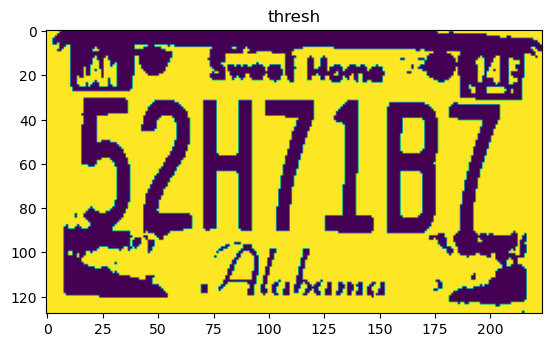

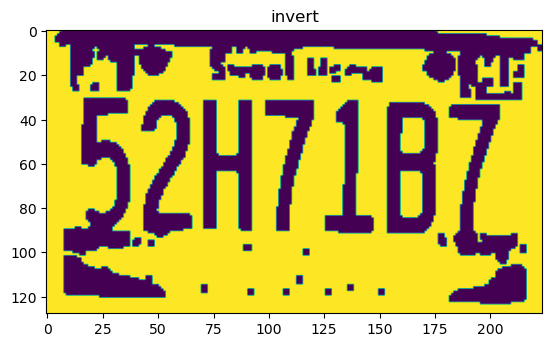

S2H71BC



In [28]:
import pytesseract
import cv2
from matplotlib import pyplot as plt

path = 'test/ALABAMA/1.jpg'

image = cv2.imread(path)
def show_image(image, title='Image'):
    plt.imshow(image)
    plt.title(title)
    plt.show()
    
def blur_thresh(image):
    # Grayscale, Gaussian blur, Otsu's threshold
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    return thresh
thresh = blur_thresh(image)
invert = 255 - thresh
show_image(invert, 'thresh')

def denoise(image):
    # Morph open to remove noise and invert image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=1)
    return opening

opening = denoise(thresh)
invert = 255 - opening
show_image(invert, 'invert')

# Perform text extraction
config = ('-l eng --psm 6') # eng is English, psm 6 is for a single uniform block of text
data = pytesseract.image_to_string(invert, config=config)
print(data)


## Accurracy review
It will not too difficult to find that the accuracy of detecting workds from OCR is not satisfactory, especially finding the contours of text within the image

In [29]:
!pip install --upgrade imutils

# import the necessary packages
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import time

[INFO] loading EAST text detector...
[INFO] text detection took 0.131969 seconds


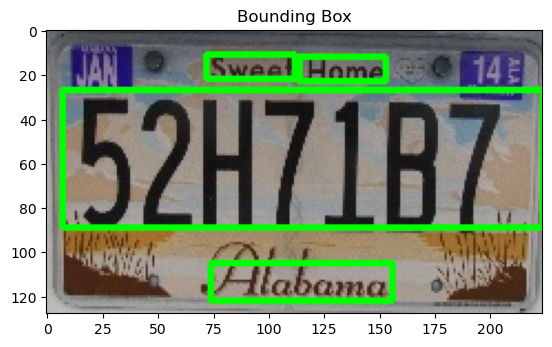

In [30]:
min_confidence = 0.8
# load the input image and grab the image dimensions
# image = cv2.imread(args["image"])
orig = image.copy()
(H, W) = image.shape[:2]
# set the new width and height and then determine the ratio in change
# for both the width and height
(newW, newH) = (320, 320)
rW = W / float(newW)
rH = H / float(newH)
# resize the image and grab the new image dimensions
image_res = cv2.resize(image, (newW, newH))
(H, W) = image_res.shape[:2]

# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet("model/frozen_east_text_detection.pb")
# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image_res, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()
# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))

# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []
# loop over the number of rows
for y in range(0, numRows):
	# extract the scores (probabilities), followed by the geometrical
	# data used to derive potential bounding box coordinates that
	# surround text
	scoresData = scores[0, 0, y]
	xData0 = geometry[0, 0, y]
	xData1 = geometry[0, 1, y]
	xData2 = geometry[0, 2, y]
	xData3 = geometry[0, 3, y]
	anglesData = geometry[0, 4, y]
	# loop over the number of columns
	for x in range(0, numCols):
		# if our score does not have sufficient probability, ignore it
		if scoresData[x] < min_confidence:
			continue
		# compute the offset factor as our resulting feature maps will
		# be 4x smaller than the input image
		(offsetX, offsetY) = (x * 4.0, y * 4.0)
		# extract the rotation angle for the prediction and then
		# compute the sin and cosine
		angle = anglesData[x]
		cos = np.cos(angle)
		sin = np.sin(angle)
		# use the geometry volume to derive the width and height of
		# the bounding box
		h = xData0[x] + xData2[x]
		w = xData1[x] + xData3[x]
		# compute both the starting and ending (x, y)-coordinates for
		# the text prediction bounding box
		endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
		endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
		startX = int(endX - w)
		startY = int(endY - h)
		# add the bounding box coordinates and probability score to
		# our respective lists
		rects.append((startX, startY, endX, endY))
		confidences.append(scoresData[x])
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)

# remove the bounding boxes that are too narrow or too short
boxes = [box for box in boxes if (box[2]-box[0]) > 50]

# make sure the largetest bounding box is fully expended horizontally
boxes = sorted(boxes, key=lambda box: (box[2]-box[0])*(box[3]-box[1]))
startX, startY, endX, endY = boxes[-1]
startX = 0 if startX > W/4 else startX
endX = W if endX < 3*W/4 else endX
boxes[-1] = (startX, startY, W, endY)

# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the bounding box coordinates based on the respective
	# ratios
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)
	# draw the bounding box on the image
	cntImage = cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
 
show_image(cntImage, 'Bounding Box')

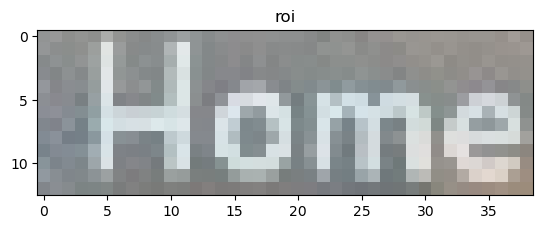

Home



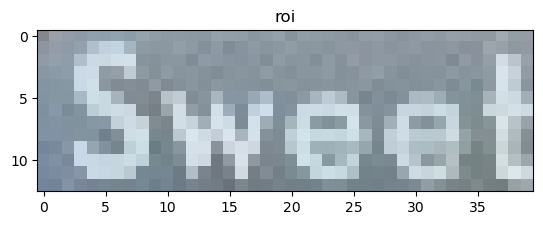

Sweet



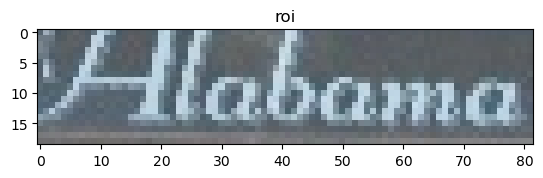

H+Hlabama



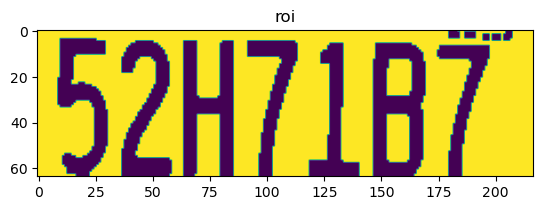

DOHTIAT



In [33]:
# extract the text from boxes
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    sx = int(startX * rW)
    sy = int(startY * rH)
    ex = int(endX * rW)
    ey = int((endY+5) * rH)
    # extract the region of interest
    roi = image[sy:ey, sx:ex]
    roi = blur_thresh(roi) if endY - startY > 50 else roi
    roi = denoise(roi) if endY - startY > 50 else roi
    roi = 255 - roi 
    plt.imshow(roi)
    plt.title('roi')
    plt.show()
    # configuration setting to convert image to string.
    config = ('-l eng --psm 6') # eng is English, psm 6 is for a single uniform block of text
    # now feeding image to tesseract
    det = pytesseract.image_to_string(roi, config=config)
    print(det)

## Analyze all images in test folder

In [32]:
image_map = {}
# read subdirectory under test folder and save to a map
import os
for root, dirs, files in os.walk("test"):
    image_map[root] = files
    print(root)
    print(dirs)
    print(files)
    print("===========")

test
['MISSOURI', 'ALASKA', 'NEW HAMPSHIRE', 'ILLINOIS', 'VIRGINIA', 'WASHINGTON', 'VERMONT', 'SOUTH DAKOTA', 'GEORGIA', 'CONNECTICUT', 'ALABAMA', 'OKLAHOMA', 'COLORADO', 'OHIO', 'MAINE', 'UTAH', 'SOUTH CAROLINA', 'DELAWARE', 'INDIANA', 'ARKANSAS', 'IOWA', 'NEW JERSEY', 'WISCONSIN', 'MICHIGAN', 'ARIZONA', 'MASSACHUSETTS', 'MONTANA', 'NEW YORK', 'WYOMING', 'MINNESOTA', 'WEST VIRGINIA', 'NORTH DAKOTA', 'FLORIDA', 'KENTUCKY', 'LOUISIANA', 'MARYLAND', 'TEXAS', 'HAWAI', 'RHODE ISLAND', 'KANSAS', 'PENNSYLVANIA', 'NORTH CAROLINA', 'NEBRASKA', 'TENNESSEE', 'IDAHO', 'OREGON', 'NEVADA', 'CALIFORNIA', 'NEW MEXICO', 'MISSIPPI']
['.DS_Store']
test/MISSOURI
[]
['4.jpg', '5.jpg', '2.jpg', '3.jpg', '1.jpg']
test/ALASKA
[]
['4.jpg', '5.jpg', '2.jpg', '3.jpg', '1.jpg']
test/NEW HAMPSHIRE
[]
['4.jpg', '5.jpg', '2.jpg', '3.jpg', '1.jpg']
test/ILLINOIS
[]
['4.jpg', '5.jpg', '2.jpg', '3.jpg', '1.jpg']
test/VIRGINIA
[]
['4.jpg', '5.jpg', '2.jpg', '3.jpg', '1.jpg']
test/WASHINGTON
[]
['4.jpg', '5.jpg', '2.jpg

With use of tesseract, we will extract the text from the mage.


## Compare the performance with Spark OCR
https://nlp.johnsnowlabs.com/docs/en/ocr

## Improve the performance by utilizing GPU

# Ultimate Challenge: Hand-made OCR optimized for license Plate Recognition (good to have)

# 